<a href="https://colab.research.google.com/github/36thNinja/36thNinja.github.io/blob/master/Interpretability_V0_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt

In [2]:
class ResultInterpreter:
  def interpret(self,IMAGE_PATH,model,CLASS_INDEX,layer_name=None,use_guided_grads=False,blending_coefficient = 0.36):

    model_input_image_dim = model.layers[0].output_shape[0][1:3]

    if layer_name is None:
      for layer in model.layers:
        if "conv" in layer.name:
          layer_name = layer.name

    if layer_name is None:
      raise ValueError("No Convolution layer found to perform interpretation")

    img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=model_input_image_dim)
    img = tf.keras.preprocessing.image.img_to_array(img)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
      conv_outputs, predictions = grad_model(np.array([img]))
      loss = predictions[:, CLASS_INDEX]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    #Design choice to use guided back prop instead of deconvolution
    if use_guided_grads:
      guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads
    else:
      guided_grads = grads
    

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
      cam += w * output[:, :, i]

    cam = cam.numpy()
    scaled_cam = (cam - cam.min()) / (cam.max() - cam.min())
    im = Image.fromarray(np.uint8(scaled_cam*255))
    im = im.resize(model_input_image_dim,Image.BICUBIC)
    resized_cam = np.asarray(im)

    cmap = plt.get_cmap('jet')
    rgba_activations = cmap(resized_cam)
    rgb_activations = np.delete(rgba_activations, 3, 2)
    rgb_activations_image = Image.fromarray(np.uint8(rgb_activations*255))

    input_image = Image.fromarray(np.uint8(img*255))
    blended_image = Image.blend(rgb_activations_image, input_image, alpha=blending_coefficient)

    result = np.asarray(blended_image)


    return result

In [3]:
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

In [4]:
!wget https://upload.wikimedia.org/wikipedia/commons/1/1a/Arthur%2C_the_cat.jpg 
!mv Arthur,_the_cat.jpg cat.jpg

IMAGE_PATH = 'cat.jpg'
#LAYER_NAME = 'block5_conv3'
CAT_CLASS_INDEX = 281

--2020-09-15 07:10:34--  https://upload.wikimedia.org/wikipedia/commons/1/1a/Arthur%2C_the_cat.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2636769 (2.5M) [image/jpeg]
Saving to: ‘Arthur,_the_cat.jpg’

Arthur,_the_cat.jpg 100%[===================>]   2.51M  8.58MB/s    in 0.3s    

2020-09-15 07:10:35 (8.58 MB/s) - ‘Arthur,_the_cat.jpg’ saved [2636769/2636769]



In [5]:
interpreter = ResultInterpreter()
result = interpreter.interpret(IMAGE_PATH,model,CAT_CLASS_INDEX)

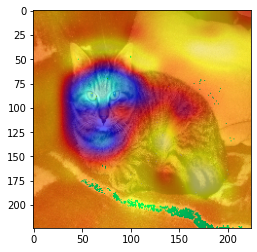

In [6]:
import matplotlib.pyplot as plt

rgb_img = Image.fromarray(np.uint8((result)*255))
#rgb_img = np.delete(rgb_img, 3, 2)
plt.imshow(rgb_img)